Strategy Performance:
Start                         2025-05-06 10:57:00
End                           2025-05-20 04:01:00
Period                           13 days 17:05:00
Start Value                                1000.0
End Value                              773.989606
Total Return [%]                       -22.601039
Benchmark Return [%]                    13.710773
Max Gross Exposure [%]                  76.925794
Total Fees Paid                        272.565244
Max Drawdown [%]                         22.82768
Max Drawdown Duration            13 days 16:46:00
Total Trades                                34436
Total Closed Trades                         34303
Total Open Trades                             133
Open Trade PnL                          -0.049856
Win Rate [%]                            31.737749
Best Trade [%]                         187.751685
Worst Trade [%]                        -65.487614
Avg Winning Trade [%]                    1.351496
Avg Losing Trade [%]        

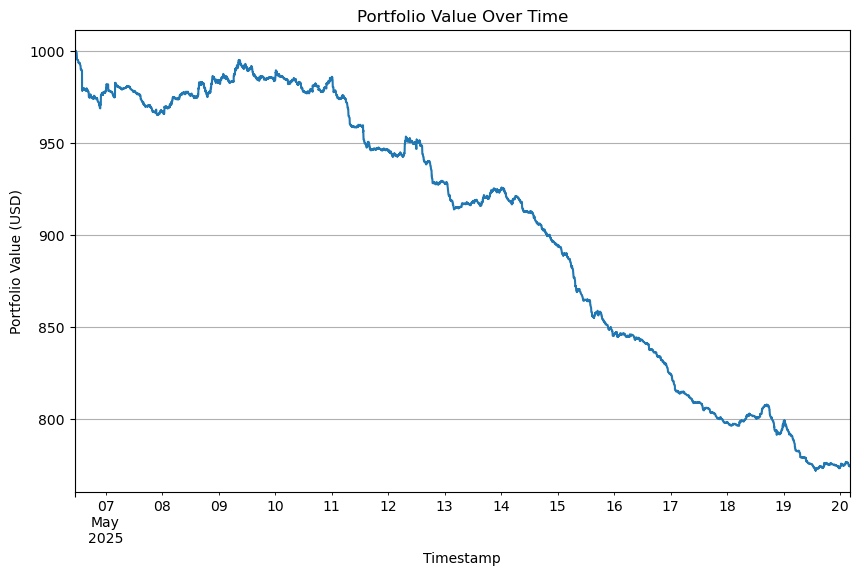

IndexingError: Columns only: This object already contains one column of data

In [16]:
import os
import sys
from datetime import datetime, timedelta
import pandas as pd
import ccxt
import vectorbt as vbt
import matplotlib.pyplot as plt

# --- Configuration ---
HIST_DIR = '/data/historical'
os.makedirs(HIST_DIR, exist_ok=True)

# Time window: last 14 days
end_time = datetime.utcnow()
start_time = end_time - timedelta(days=14)
since = int(start_time.timestamp() * 1000)

# Initialize Binance US exchange via CCXT
exchange = ccxt.binanceus({'enableRateLimit': True})
try:
    exchange.load_markets()
except Exception as e:
    print(f"Error: Binance US markets not available. {e}")
    sys.exit(1)

# Filter spot symbols ending in USDT
symbols = [sym for sym, m in exchange.markets.items()
           if m.get('spot', False) and sym.endswith('/USDT')]

# Fetch or load OHLCV data for each symbol
ohlcv_data = {}
for symbol in symbols:
    filename = symbol.replace('/', '') + '.parquet'
    filepath = os.path.join(HIST_DIR, filename)

    if os.path.exists(filepath):
        df = pd.read_parquet(filepath)
    else:
        all_bars = []
        since_ts = since
        while True:
            try:
                bars = exchange.fetch_ohlcv(symbol, timeframe='1m', since=since_ts, limit=1000)
            except Exception as e:
                print(f"Warning: Failed to fetch OHLCV for {symbol}. Skipping. {e}")
                break
            if not bars:
                break
            all_bars.extend(bars)
            since_ts = bars[-1][0] + 60 * 1000
            if bars[-1][0] >= int(end_time.timestamp() * 1000):
                break

        if not all_bars:
            continue
        df = pd.DataFrame(all_bars, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        df = df.loc[df.index >= start_time]
        df.to_parquet(filepath)

    ohlcv_data[symbol] = df

if not ohlcv_data:
    print("No market data available. Exiting.")
    sys.exit(1)

# Build DataFrames for close and low prices
price_df = pd.DataFrame({sym: df['close'] for sym, df in ohlcv_data.items()})
low_df   = pd.DataFrame({sym: df['low']   for sym, df in ohlcv_data.items()})
price_df.index.name = 'timestamp'
low_df.index.name   = 'timestamp'

# Calculate Bollinger Bands (20-period SMA, 2 std dev)
sma = price_df.rolling(window=20).mean()
rolling_std = price_df.rolling(window=20).std(ddof=0)
upper_band = sma + 2 * rolling_std
lower_band = sma - 2 * rolling_std

# Generate entry signals: price touches/exceeds upper band
entries = price_df >= upper_band

# Generate timed exit signals: 10 minutes after entry
timed_exits = entries.shift(2).fillna(False)

# Calculate entry price series to apply stop-loss
entry_price_df = price_df.where(entries).ffill()

# Generate stop-loss exit signals: price low drops 10% below entry price
stop_exits = low_df <= entry_price_df * 0.90

# Combine exit signals: either timed exit or stop-loss exit
exits = timed_exits | stop_exits

# Backtest: init $1000 total, 1% of portfolio per trade, 0.1% fees
pf = vbt.Portfolio.from_signals(
    close=price_df,
    entries=entries,
    exits=exits,
    init_cash=1000.0,
    fees=0.001,
    size=0.01, size_type='percent',  # use 'targetpercent' for percent sizing
    cash_sharing=True
)

# Display overall stats
print("Strategy Performance:")
print(pf.stats())

# Plot portfolio total value over time
plt.figure(figsize=(10, 6))
pf.value().plot()
plt.title('Portfolio Value Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Portfolio Value (USD)')
plt.grid(True)
plt.show()

# Optional: save stats and trades per asset
stats_df = pf.stats()
stats_df.to_csv('/data/bollinger_strategy_stats.csv')

for sym in ohlcv_data.keys():
    trades_sym = pf.trades[sym].records_readable
    trades_sym.to_csv(f"/data/{sym.replace('/', '')}_trades.csv", index=False)


In [3]:
# Imports and setup
import os
import pandas as pd
import numpy as np
import ccxt
import vectorbt as vbt
from gluonts.dataset.common import ListDataset
from gluonts.torch.model.deepar import DeepAREstimator

# --- Config ---
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)
prediction_length = 10
context_length = 30
init_cash = 100000.0
position_size = 0.05  # 5% per trade
train_ratio = 0.8

# --- Step 1: Fetch data from Binance and cache to Parquet ---
exchange = ccxt.binanceus()  # Use Binance US due to regional restrictions
exchange.load_markets()
usdt_symbols = [s for s in exchange.symbols if s.endswith('/USDT')]

# Get data from last 14 days
two_weeks_ms = 14 * 24 * 60 * 60 * 1000
end_time = exchange.milliseconds()
start_time = end_time - two_weeks_ms

market_data = {}
def fetch_symbol_data(symbol: str, since_ms: int):
    fname = symbol.replace("/", "_") + ".parquet"
    path = os.path.join(DATA_DIR, fname)
    if os.path.exists(path):
        return pd.read_parquet(path)
    all_ohlcv = []
    while True:
        ohlcv = exchange.fetch_ohlcv(symbol, '1m', since=since_ms, limit=1000)
        if not ohlcv:
            break
        all_ohlcv.extend(ohlcv)
        since_ms = ohlcv[-1][0] + 60_000
        if len(ohlcv) < 1000:
            break
    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df.to_parquet(path)
    return df

for symbol in usdt_symbols:
    fname = symbol.replace("/", "_") + ".parquet"
    path = os.path.join(DATA_DIR, fname)
    if os.path.exists(path):
        market_data[symbol] = pd.read_parquet(path)
        continue
    try:
        df = fetch_symbol_data(symbol, start_time)
        market_data[symbol] = df
    except Exception as e:
        print(f"{symbol} failed: {e}")

# --- Step 2: Train DeepAR on all time series ---
import torch
print("✅ GPU is available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Using device:", torch.cuda.get_device_name(0))

device = "cuda" if torch.cuda.is_available() else "cpu"
train_data = []
for symbol, df in market_data.items():
    if df.empty:
        continue
    n = len(df)
    idx = int(n * train_ratio)
    close = df['close'].iloc[:idx].values
    volume = df['volume'].iloc[:idx].values
    combined = close  # DeepAR expects 1D 'target'. Volume can be added as a feature if supported.  # shape (2, time)
    train_data.append({
        "target": close,
        "feat_dynamic_real": [df['volume'].iloc[:idx].values, df['close'].iloc[:idx].rolling(14).apply(lambda x: 100 - (100 / (1 + ((x[-1] - x.min()) / (x.max() - x[-1] + 1e-9)))), raw=True).fillna(0).values],
        "start": df.index[0],
        "item_id": symbol
    })
training_ds = ListDataset(train_data, freq="T")

estimator = DeepAREstimator(
    freq="T",
    prediction_length=prediction_length,
    context_length=context_length,
    num_layers=2,
    hidden_size=40,
    trainer_kwargs={
        "max_epochs": 15,
        "accelerator": "gpu" if device == "cuda" else "cpu",
        "devices": 1
    }
)
predictor = estimator.train(training_data=training_ds)

# --- Step 3: Generate signals from DeepAR ---
entries, exits = {}, {}
skipped_lengths = []
for symbol, df in market_data.items():
    n = len(df)
    idx = int(n * train_ratio)
    test_index = df.index[idx:]
    e_sig = np.zeros(n, dtype=bool)
    x_sig = np.zeros(n, dtype=bool)
    in_position = False
    exit_idx = -1

    for i in range(idx, n - prediction_length):
        if in_position and i < exit_idx:
            continue
        elif in_position:
            in_position = False

        c_hist = df['close'].iloc[max(0, i-context_length):i].values
        history = c_hist  # Only use close price (1D) since DeepAR expects 1D target
        pred_input = ListDataset([{
            "target": history,
            "feat_dynamic_real": [
                df['volume'].iloc[max(0, i-context_length):i].values,
                df['close'].iloc[max(0, i-context_length):i].rolling(14).apply(lambda x: 100 - (100 / (1 + ((x[-1] - x.min()) / (x.max() - x[-1] + 1e-9)))), raw=True).fillna(0).values
            ],
            "start": df.index[max(0, i-context_length)]
        }], freq="T")
        forecast = next(predictor.predict(pred_input))
        if forecast.mean[-1] > df['close'].iloc[i]:
            e_sig[i] = True
            x_idx = i + prediction_length
            if x_idx < n:
                x_sig[x_idx] = True
            in_position = True
            exit_idx = x_idx

    if len(e_sig) == n:
        entries[symbol] = e_sig
        exits[symbol] = x_sig
    else:
        print(f"Skipping {symbol} due to mismatched signal length: {len(e_sig)} vs {n}")
        skipped_lengths.append(symbol)

# --- Step 4: Backtest using vectorbt ---
price_df = pd.DataFrame({s: df['close'] for s, df in market_data.items()})
n = min(map(len, price_df.values.T))
price_df = price_df.iloc[-n:]

entries_df = pd.DataFrame(entries).iloc[-n:]
exits_df = pd.DataFrame(exits).iloc[-n:]

pf = vbt.Portfolio.from_signals(
    close=price_df,
    entries=entries_df,
    exits=exits_df,
    init_cash=init_cash,
    fees=0.001,
    slippage=0.001,
    size=position_size,
    size_type='valuepercent',
    cash_sharing=True
)

print(pf.stats())

# Plot the performance
pf.plot().show()


✅ GPU is available: True
Using device: NVIDIA GeForce RTX 3090 Ti


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\saber\anaconda3\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode  | In sizes                                                      | Out sizes   
-----------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 24.9 K | train | [[1, 1], [1, 1], [1, 211, 6], [1, 211], [1, 211], [1, 10, 6]] | [1, 100, 10]
-----------------------------------------------------------------------------------------------------------------------------
24.9 K    Trainable params
0         Non-trainable params
24.9 K    Total params
0.100     Total estimated model params size (MB)
11        Modules in train mode
0     

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached -0.55893 (best -0.55893), saving model to 'C:\\Users\\saber\\OneDrive\\Documents\\GitHub\\CryptoBot4Dummies\\lightning_logs\\version_7\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached -2.92812 (best -2.92812), saving model to 'C:\\Users\\saber\\OneDrive\\Documents\\GitHub\\CryptoBot4Dummies\\lightning_logs\\version_7\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached -3.47000 (best -3.47000), saving model to 'C:\\Users\\saber\\OneDrive\\Documents\\GitHub\\CryptoBot4Dummies\\lightning_logs\\version_7\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached -3.90242 (best -3.90242), saving model to 'C:\\Users\\saber\\OneDrive\\Documents\\GitHub\\CryptoBot4Dummies\\lightning_logs\\version_7\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached -4.23062 (best -4.23062), saving model to '

KeyboardInterrupt: 

In [27]:
# Imports and setup
import os
import glob
import pandas as pd
import numpy as np
import ccxt
import vectorbt as vbt
from gluonts.dataset.common import ListDataset
from gluonts.torch.model.deepar import DeepAREstimator
import concurrent.futures
import torch

# Use Tensor Cores for faster ops
torch.set_float32_matmul_precision('high')
print("Starting DeepAR backtest pipeline with enhanced logging...")

# --- Config ---
DATA_DIR = "data/binance_back_testing"
os.makedirs(DATA_DIR, exist_ok=True)
prediction_length = 10
context_length = 120
init_cash = 100000.0
position_size = 0.05  # 5% per trade
max_workers = 32      # threads for signal generation
fetch_workers = 8     # threads for fetching

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Step 1: Parallel fetch & cache data ---
print("[Step 1] Fetching OHLCV in parallel...")
exchange = ccxt.binanceus()
exchange.load_markets()
usdt_symbols = [s for s in exchange.symbols if s.endswith('/USDT')]
if not usdt_symbols:
    raise RuntimeError("No USDT symbols found")
if len(usdt_symbols) > 10:
    print(f"    Found {len(usdt_symbols)} symbols; fetching first 10 for demo.")
    usdt_symbols = usdt_symbols[:10]

six_weeks_ms = 42 * 24 * 60 * 60 * 1000
end_time = exchange.milliseconds()
start_time = end_time - six_weeks_ms

def fetch_and_cache(symbol: str):
    print(f"    [Fetch] {symbol}")
    fname = symbol.replace('/', '_') + '.parquet'
    path = os.path.join(DATA_DIR, fname)
    if os.path.exists(path):
        print(f"      Cached, skipping")
        return
    all_ohlcv = []
    since_ms = start_time
    while True:
        chunk = exchange.fetch_ohlcv(symbol, '1m', since=since_ms, limit=1000)
        if not chunk:
            break
        all_ohlcv.extend(chunk)
        since_ms = chunk[-1][0] + 60_000
        if len(chunk) < 1000:
            break
    df = pd.DataFrame(all_ohlcv, columns=['timestamp','open','high','low','close','volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['symbol'] = symbol
    df.to_parquet(path)
    print(f"      Saved {len(df)} rows for {symbol}")

with concurrent.futures.ThreadPoolExecutor(max_workers=fetch_workers) as ex:
    ex.map(fetch_and_cache, usdt_symbols)
print("[Step 1] Fetch complete\n")

# --- Step 1b: Load data + RSI ---
print("[Step 1b] Loading and computing RSI...")
market_data = {}
for path in glob.glob(os.path.join(DATA_DIR, '*.parquet')):
    sym = os.path.basename(path).replace('.parquet','').replace('_','/')
    df = pd.read_parquet(path).set_index('timestamp')
    delta = df['close'].diff()
    up = delta.clip(lower=0); down = -delta.clip(upper=0)
    ma_up = up.ewm(span=14, adjust=False).mean()
    ma_down = down.ewm(span=14, adjust=False).mean()
    df['rsi'] = 100 - (100/(1 + ma_up/(ma_down + 1e-9)))
    df['rsi'] = df['rsi'].fillna(0)
    market_data[sym] = df
print(f"    Prepared {len(market_data)} symbols\n")

# --- Step 2: Train DeepAR with sliding windows ---
print("[Step 2] Preparing sliding-window training data...")
train_items = []
window_stride = prediction_length
for symbol, df in market_data.items():
    n = len(df)
    cutoff = n - (14 * 24 * 60)
    if cutoff <= context_length + prediction_length:
        print(f"    Skipping {symbol}: insufficient data (n={n})")
        continue
    for end_i in range(context_length + prediction_length, cutoff, window_stride):
        start_i = end_i - (context_length + prediction_length)
        train_items.append({
            'target': df['close'].iloc[start_i:end_i].to_numpy(),
            'feat_dynamic_real': [
                df['volume'].iloc[start_i:end_i].to_numpy(),
                df['rsi'].iloc[start_i:end_i].to_numpy()
            ],
            'start': df.index[start_i],
            'item_id': symbol
        })
print(f"    Training on {len(train_items)} windows")
training_ds = ListDataset(train_items, freq='T')
estimator = DeepAREstimator(
    freq='T',
    prediction_length=prediction_length,
    context_length=context_length,
    num_layers=3,
    hidden_size=100,
    batch_size=1024,  # leverage more GPU memory for larger inference batches
    trainer_kwargs={
        'max_epochs': 1,
        'accelerator': 'gpu' if device.type=='cuda' else 'cpu',
        'devices': 1,
        'precision': 16,
        'logger': False,
        'limit_val_batches': 0,
    }
)
predictor = estimator.train(training_data=training_ds)
if hasattr(predictor, 'network'):
    predictor.network.to(device)
    predictor.network.eval()
    predictor.network.half()
print("    Training complete\n")

# --- Step 3: Vectorized window collection & inference ---
print("[Step 3-super] Vectorized window collection & inference…")
from numpy.lib.stride_tricks import sliding_window_view

map_info = []  # list of (symbol, idx)
close_win_list = []
vol_win_list = []
rsi_win_list = []

test_win = 14 * 24 * 60
for symbol, df in market_data.items():
    arr_close = df['close'].values
    arr_vol = df['volume'].values
    arr_rsi = df['rsi'].values
    n = len(arr_close)
    total_req = test_win + context_length + prediction_length
    if n < total_req:
        print(f"    Skipping {symbol}: insufficient data (n={n}, need>= {total_req})")
        continue
    # compute sliding windows on CPU
    starts = np.arange(n - test_win - context_length + 1)
    # valid start positions for windows
    valid = starts[starts >= 0][:(test_win)]
    closes = sliding_window_view(arr_close, context_length)[valid]
    vols   = sliding_window_view(arr_vol, context_length)[valid]
    rsis   = sliding_window_view(arr_rsi, context_length)[valid]
    count = closes.shape[0]
    # record indices at window end
    idxs = valid + context_length - 1
    map_info.extend([(symbol, int(i)) for i in idxs])
    close_win_list.append(closes)
    vol_win_list.append(vols)
    rsi_win_list.append(rsis)

# stack all windows
X_close = torch.tensor(np.vstack(close_win_list), dtype=torch.float32, device=device)
X_vol   = torch.tensor(np.vstack(vol_win_list), dtype=torch.float32, device=device)
X_rsi   = torch.tensor(np.vstack(rsi_win_list), dtype=torch.float32, device=device)
print(f"    Collected and moved {len(map_info)} windows to GPU")

# run one-shot inference
with torch.no_grad():
    from torch.amp import autocast
    with autocast(device_type='cuda', enabled=True):
        dist = predictor.network(
            past_target=X_close,
            feat_dynamic_real=torch.stack([X_vol, X_rsi], dim=1)
        )
means = dist.mean.cpu().numpy()
print(f"    Computed {means.shape[0]} forecasts")

# initialize signals
entries = {sym: np.zeros(len(market_data[sym]), dtype=bool) for sym,_ in map_info}
exits   = {sym: np.zeros(len(market_data[sym]), dtype=bool) for sym,_ in map_info}
# map predictions back
for (symbol, idx), window_mean in zip(map_info, means):
    price = market_data[symbol]['close'].iloc[idx]
    if window_mean[-1] >= price * 1.05:
        entries[symbol][idx] = True
        ex_i = idx + prediction_length
        if ex_i < len(entries[symbol]):
            exits[symbol][ex_i] = True
print("[Step 3-super] Signal gen complete")

# --- Step 4: Backtest ---
print("[Step 4] Backtesting with vectorbt...")
symbols = list(entries.keys())
price_df = pd.DataFrame({s: market_data[s]['close'] for s in symbols}).dropna(axis=1)
n = min(map(len, price_df.values.T))
price_df = price_df.iloc[-n:]
entries_df = pd.DataFrame({s: entries[s][-n:] for s in symbols})
exits_df   = pd.DataFrame({s: exits[s][-n:] for s in symbols})
pf = vbt.Portfolio.from_signals(
    close=price_df, entries=entries_df, exits=exits_df,
    init_cash=init_cash, fees=0.001, slippage=0.001,
    size=position_size, size_type='Percent', cash_sharing=True
)
print("    Backtest complete")
stats = pf.stats(); print(stats)
stats.to_csv(os.path.join(DATA_DIR, "backtest_stats.csv"))
pf.plot().show()
print("Pipeline finished")


Starting DeepAR backtest pipeline with enhanced logging...
Using device: cuda
[Step 1] Fetching OHLCV in parallel...
    Found 192 symbols; fetching first 10 for demo.
    [Fetch] 1INCH/USDT
      Cached, skipping
    [Fetch] AAVE/USDT
      Cached, skipping
    [Fetch] ACH/USDT
    [Fetch] ADA/USDT
      Cached, skipping
    [Fetch] ADX/USDT
      Cached, skipping
      Cached, skipping
    [Fetch] AIXBT/USDT
    [Fetch] ALGO/USDT
    [Fetch] ALICE/USDT
      Cached, skipping
    [Fetch] ALPINE/USDT
      Cached, skipping
      Cached, skipping
      Cached, skipping
    [Fetch] ANKR/USDT
      Cached, skipping
[Step 1] Fetch complete

[Step 1b] Loading and computing RSI...
    Prepared 192 symbols

[Step 2] Preparing sliding-window training data...
    Skipping 1INCH/USDT: insufficient data (n=600)
    Skipping AAVE/USDT: insufficient data (n=600)
    Skipping AIXBT/USDT: insufficient data (n=17894)
    Skipping ANT/USDT: insufficient data (n=0)
    Skipping BOND/USDT: insufficient d

C:\Users\saber\anaconda3\Lib\site-packages\lightning\fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\saber\anaconda3\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
C:\Users\saber\anaconda3\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\saber\OneDrive\Documents\GitHub\CryptoBot4Dummies\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode  | In sizes                                                      | Out sizes   
-----------------------------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached -0.87651 (best -0.87651), saving model to 'C:\\Users\\saber\\OneDrive\\Documents\\GitHub\\CryptoBot4Dummies\\checkpoints\\epoch=0-step=50-v16.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.


    Training complete

[Step 3-super] Vectorized window collection & inference…
    Skipping 1INCH/USDT: insufficient data (n=600, need>= 20290)
    Skipping AAVE/USDT: insufficient data (n=600, need>= 20290)
    Skipping AIXBT/USDT: insufficient data (n=17894, need>= 20290)
    Skipping ANT/USDT: insufficient data (n=0, need>= 20290)
    Skipping BOND/USDT: insufficient data (n=0, need>= 20290)
    Skipping BUSD/USDT: insufficient data (n=0, need>= 20290)
    Skipping CUDOS/USDT: insufficient data (n=0, need>= 20290)
    Skipping DAR/USDT: insufficient data (n=0, need>= 20290)
    Skipping FLOKI8/USDT: insufficient data (n=0, need>= 20290)
    Skipping FTM/USDT: insufficient data (n=0, need>= 20290)
    Skipping GAL/USDT: insufficient data (n=0, need>= 20290)
    Skipping HNT/USDT: insufficient data (n=0, need>= 20290)
    Skipping JASMY/USDT: insufficient data (n=0, need>= 20290)
    Skipping KAITO/USDT: insufficient data (n=7812, need>= 20290)
    Skipping MATIC/USDT: insufficient d

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1592066400 bytes.

In [25]:
# Diana 80k
# June 140k
# Me 100k
# Miki 101k
# Molly 110k
# Tequlia 110k

In [1]:
pip install cudf

Note: you may need to restart the kernel to use updated packages.Collecting cudf
  Using cached cudf-0.6.1.post1.tar.gz (1.1 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for cudf
Failed to build cudf



  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [47 lines of output]
  running bdist_wheel
  running build
  C:\Users\saber\anaconda3\Lib\site-packages\setuptools\_distutils\cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
  !!
  
          ********************************************************************************
          Please avoid running ``setup.py`` directly.
          Instead, use pypa/build, pypa/installer or other
          standards-based tools.
  
          See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
          ********************************************************************************
  
  !!
    self.initialize_options()
  installing to build\bdist.win-amd64\wheel
  running install
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\User

In [8]:
pip install vectorbt gluonts torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.
